In [ ]:
import torch
from torch import nn
import torchvision.transforms as tt
from torchvision.models import resnet50
import requests
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary


#Switch off the grad since this notebook uses pretrained weights
torch.set_grad_enabled(False);

In [ ]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]
print(f"The length of classes in COCO dataset is {len(CLASSES)}")

# colors for plotting objects
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

The length of classes in COCO dataset is 91


## Create Models

### Pretrained Torch Hub model

In [ ]:
#List of available models in this github torch hub.
torch.hub.list('facebookresearch/detr')

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


['Backbone',
 'DETR',
 'DETRsegm',
 'Joiner',
 'PositionEmbeddingSine',
 'PostProcess',
 'PostProcessPanoptic',
 'Transformer',
 'detr_resnet101',
 'detr_resnet101_dc5',
 'detr_resnet101_panoptic',
 'detr_resnet50',
 'detr_resnet50_dc5',
 'detr_resnet50_dc5_panoptic',
 'detr_resnet50_panoptic']

In [ ]:
torch_hub_model = torch.hub.load('facebookresearch/detr','detr_resnet101',pretrained=True)

#Change model to evaluate model for predictions
torch_hub_model.eval()

#move to gpu if it's available
if torch.cuda.is_available():
    torch_hub_model = torch_hub_model.cuda()

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


### Custom DETR model

![DETR](Images/DETR.jpeg)

In [ ]:
class DETR(nn.Module):
    """
    This DETR implementation is different from the actual implementation such as :
    -> The positional embedding are sinusodal whereas it is learnt in the paper.
    -> Positional encoding is passed at the input whereas attention is passed in the paper.
    -> Uses fully connected bounding box whereas MLP is used in the paper
    """
    def __init__(self,num_classes,hidden_dim=256,num_heads=8,n_encoder_layers=6,n_decoder_layers=6):
        super().__init__()

        #resnet-50 backbone
        self.backbone = resnet50()

        del self.backbone.fc #Deletes last fc layer

        self.conv = nn.Conv2d(in_channels=2048,out_channels=hidden_dim,kernel_size=1)

        self.transformer = nn.Transformer(d_model=hidden_dim,nhead=num_heads,
                                          num_encoder_layers=n_encoder_layers,num_decoder_layers=n_decoder_layers)
        
        #For predicting class
        self.linear_class = nn.Linear(hidden_dim,num_classes+1)

        #For predicting bb
        self.linear_bbox = nn.Linear(hidden_dim,4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
        

        #For encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2)) # shape -> (50,128)
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2)) # shape -> (50,128)



    def forward(self,inputs):

        #forward pass the inputs through the resnet50 upto avgpool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.conv(x) #convert 2048 channels to 512 channels

        #positional embedding
        H, W = x.shape[-2:] #The last 2 dimensions are height(sequence_len) and width(dim)
        pos = torch.cat([
              self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1), 
              self.row_embed[:H].unsqueeze(1).repeat(1, W, 1), 
        ], dim=-1).flatten(0,1).unsqueeze(1)

        #Pass through transformer
        t = self.transformer(pos + 0.1 * x.flatten(2).permute(2,0,1), self.query_pos.unsqueeze(1)).transpose(0,1)

        return {'pred_logits': self.linear_class(t),
                'pred_boxes' : self.linear_bbox(t).sigmoid()} #Convert the bbox values from logits to coordinates between 0-1



In [ ]:
#Load the pretrained weights
custom_detr = DETR(num_classes = len(CLASSES) )
model_state_dict = torch.hub.load_state_dict_from_url(url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
                                                      map_location='cpu', check_hash=True)
custom_detr.load_state_dict(model_state_dict)
custom_detr.eval();

## Create an Object Detection Pipeline

In [ ]:
def decode_predictions(prediction,num_pred=10):
    print('Objects detected....')
    pred_logits = prediction['pred_logits'][0][:,:len(CLASSES)]   #Consider till length of classes
    pred_boxes = prediction['pred_boxes'][0]

    #convert logits to softmax scores
    pred_softmax_scores = pred_logits.softmax(-1)

    #Convert softmax scores into classes by taking max of the last dimension axis
    predictions = pred_softmax_scores.max(-1)

    all_predictions_classes = predictions.indices 
    total_predictions = predictions.values.shape[0]
    if num_pred <= total_predictions:
        topk = predictions.values.topk(num_pred) #Return top num_pred values and its indices
    else:
        topk = predictions.values.topk(total_predictions) #Return all pred values and its indices


    #predictions = torch.from_numpy(topk)
    pred_indices = topk.indices
    pred_values = topk.values

    pred_bb = pred_boxes[pred_indices]
    pred_classes = all_predictions_classes[pred_indices]
    #print(f"Prediction scores {pred_values.shape}")
    #print(pred_bb.shape)
    #print(pred_indices)
    #print(pred_classes)
    #print(pred_values)
    #The pred classes,values and bb(bounding box) will be used for plotting the image
    return pred_values, pred_classes, pred_bb

In [ ]:
def display_result(img,pred_values, pred_classes, pred_bb):
    IMG_W, IMG_H = img.size
    #print(IMG_W, IMG_H)
    plt.figure(figsize=(16,10))
    plt.imshow(img)
    ax = plt.gca() #Get the Current Axis

    #Annotate the image too
    annotated_img = img.copy()
    draw = ImageDraw.Draw(annotated_img)

    for value,pred_class,box,color in zip(pred_values,pred_classes,pred_bb, COLORS * 100):
        value = round(float(value.numpy()), 4) #Convert tensor to numpy_float64 to float so that you can use round()
        #print(f"{value} , {pred_class} , {box}")
        x, y, w, h = box # The x and y is the midpoint of w and h respectively
        unscaled_coord = [(x-w/2), (y-h/2),
                          (x+w/2), (y+h/2)]
        unscaled_coord = torch.stack(unscaled_coord, dim = -1) #Change(4,) to (1,4) for scaling purpose 
        bbox_coord = unscaled_coord.cpu() * torch.Tensor([IMG_W, IMG_H, IMG_W, IMG_H])
        label = CLASSES[pred_class]
        x0, y0, x1, y1 = bbox_coord.numpy()
        width = x1 - x0
        height = y1 - y0
        ax.add_patch(plt.Rectangle((x0, y0), width, height,
                                   fill=False, color=color, linewidth=3))
        text = f'{label}: {value:0.2f}'
        ax.text(x0, y0, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
        
        #Annotate the image with bounding box predictions
        color = [int(c*255) for c in color]
        #fnt = ImageFont.truetype(font="arial",size=20)
        draw.rectangle([x0,y0,x1,y1], outline=(color[0],color[1],color[2]), width=3)
        draw.text((x0,y0), text, fill=(color[0],color[1],color[2]))

    return annotated_img
        



In [ ]:
def ObjectDetectionPipeline(model,url,num_pred=10):
    img = Image.open(requests.get(url,stream=True).raw).convert('RGB')
    transform = tt.Compose([
                        #tt.Resize(IMG_SIZE),
                        tt.ToTensor(),
                        tt.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])
    transformed_img = transform(img)

    #Add a batch dimension in the first shape
    transformed_img = transformed_img.unsqueeze(0)

    #move to gpu if it's available
    if torch.cuda.is_available():
        transformed_img = transformed_img.cuda()
        model = model.cuda()

    pred = model(transformed_img)

    pred_values, pred_classes, pred_bb = decode_predictions(pred,num_pred)
    annotated_img = display_result(img,pred_values, pred_classes, pred_bb)
    return annotated_img


## Make Predictions

Objects detected....


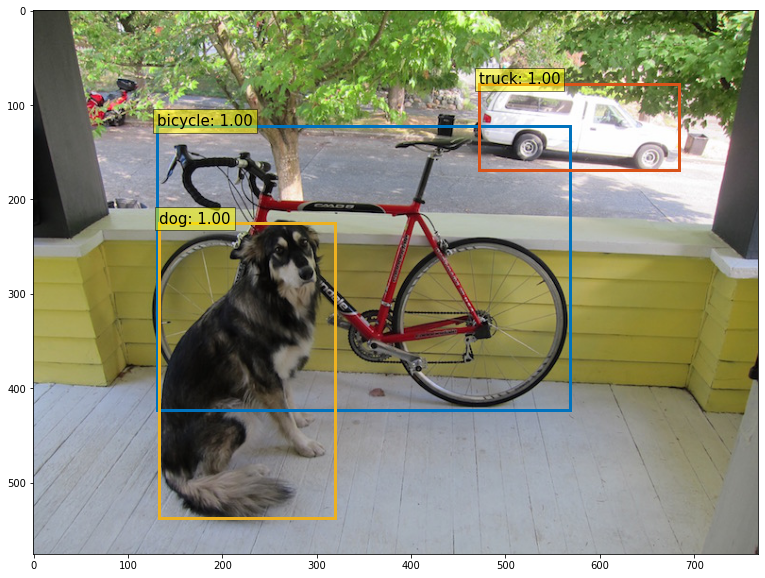

In [ ]:
#@title ##Configure Object Detection Pipeline { display-mode: "form" }

url = 'http://ai.bakevision.com/static/image/dog.jpg' #@param{type:"string"}

#Uncomment this line if you are unable to choose the params in the notebook
#ObjectDetectionPipeline(custom_detr,url2,IMG_SIZE=500,num_pred=3) 

model = custom_detr #@param ["custom_detr","torch_hub_model"] {type:"raw"}
#IMAGE_SIZE = 650 #@param {type:"slider", min:500, max:1000, step:50}
#assert IMAGE_HEIGHT <=1600 and IMAGE_WIDTH <=1600
NUM_PREDICTIONS = 3 #@param {type:"slider", min:1, max:100, step:1}

annotated_img = ObjectDetectionPipeline(model,url=url,num_pred=NUM_PREDICTIONS)